In [33]:
import sys
sys.version

'3.6.8 (default, Jan 14 2019, 11:02:34) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

In [34]:
import os
os.chdir("/project/work/Passenger_Demand")

## 패키지 설치
!pip install seaborn
!pip install haversine
!pip install pyarrow
!pip install multiprocessing_on_dill
!pip install statsmodels

In [35]:
import pandas as pd
import numpy as np
import math
import numbers

from haversine import haversine
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
from multiprocessing_on_dill import Pool, cpu_count
from functools import partial
from tqdm import tqdm
import pandas as pd
import numpy as np


def parallelize_dataframe(df, 
                          func, 
                          group_keys = None, 
                          num_cores = None,
                          **params):
    """
        Pandas DataFrame의 apply함수를 병렬처리 하는 함수

        Args: 
            df: 적용 대상 데이터프레임 (Pandas.DataFrame)
            group_keys: apply를 적용할 때 기준이되는 group by key

        Returns:
            df: (Pandas.DataFrame)
            
        Exception: 
    """

    if num_cores is None:
        num_cores = cpu_count()

    if group_keys is None:
        df_list = np.array_split(df, num_cores)
    elif group_keys is not None:
        gr_df = df.groupby(group_keys)
        df_list = [group for name, group in gr_df]
    
    func = partial(func, **params)
    tqdm.pandas()
    
    def map_func(data):
        return data.progress_apply(func, axis = 1, df=data.copy() **params)
        
        
    with Pool(num_cores) as p:

        pd_result = pd.concat(p.map(map_func, df_list))
#         pd_result = p.starmap(func, **params)
        
    return pd_result

In [37]:
pd.set_option('display.max_columns', None)

plt.rcParams['font.family'] = 'Nanum Gothic'
sns.set(font="NanumGothic")

In [38]:
%%time
bus_demand_401_10m = pd.read_parquet('model_mr/bus_demand_401_10m.parquet', engine='pyarrow')

CPU times: user 1.26 s, sys: 5.35 s, total: 6.61 s
Wall time: 1.64 s


In [39]:
bus_demand_401_10m.head(20)

,mybi_stop_id,base_ymd,transdate,totalcnt,normalcnt,studentcnt,childcnt,dayofweek,month,day,hour,min,stop_id,longitude,latitude,stop_nm,경도,위도,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
0,3100057,20200408,2020-04-08 06:30:00,3,3,0,0,수,4,8,6,30,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
1,3100057,20200408,2020-04-08 06:40:00,1,1,0,0,수,4,8,6,40,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
2,3100057,20200408,2020-04-08 09:00:00,1,1,0,0,수,4,8,9,0,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
3,3100057,20200408,2020-04-08 10:10:00,1,1,0,0,수,4,8,10,10,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
4,3100057,20200408,2020-04-08 11:30:00,1,1,0,0,수,4,8,11,30,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
5,3100057,20200408,2020-04-08 14:10:00,1,1,0,0,수,4,8,14,10,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
6,3100057,20200408,2020-04-08 14:30:00,1,1,0,0,수,4,8,14,30,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
7,3100057,20200408,2020-

import datetime

a=datetime.datetime.now()-datetime.timedelta(days=1)#하루전
a=datetime.datetime.now()-datetime.timedelta(hours=1)#한시간전
a=datetime.datetime.now()-datetime.timedelta(weeks=1)#일주일전

 

2.달,년

import dateutil.relativedelta import relativedelta
a=datetime.datetime.now()-relativedelta(months=1)#한달전
a=datetime.datetime.now()-relativedelta(years=1)#일년전

In [40]:
import datetime
from functools import partial
from tqdm import tqdm

In [69]:
col_names = ['totalcnt','normalcnt','studentcnt','childcnt']

In [70]:
new_col_names = [col_name + '_D-1' for col_name in col_names + ['check']]

In [71]:
new_col_names

['totalcnt_D-1',
 'normalcnt_D-1',
 'studentcnt_D-1',
 'childcnt_D-1',
 'check_D-1']

In [72]:
def period_before_cnt(data, df):
    col_names = ['totalcnt','normalcnt','studentcnt','childcnt']
    subset_df = df[df['stop_id'] == data['stop_id']].sort_values(['transdate']).reset_index(drop=True).copy()
    temp_df = subset_df[(subset_df['transdate'] == data['transdate'] - datetime.timedelta(days=1))][col_names].copy()
    j = 0
    while len(temp_df) == 0:
        j += 1
        if subset_df['transdate'].min() >= data['transdate'] - datetime.timedelta(days=j):
            temp_df = subset_df[(subset_df['transdate'] == data['transdate'])][col_names].copy()
            j = -1
            break
        temp_df = subset_df[(subset_df['transdate'] == data['transdate'] - datetime.timedelta(days=j))][col_names].copy()
    temp_df['check'] = 'j'
    new_col_names = [col_name + '_D-1' for col_name in col_names + ['check']]
    temp_df[new_col_names] = temp_df.reset_index(drop=True).loc[0]
    return temp_df

In [59]:
def period_before_cnt(data, df):
    result_df = df.sort_values(['stop_id', 'transdate']).copy().reset_index()
    col_names = ['totalcnt','normalcnt','studentcnt','childcnt']
    subset_df = result_df[result_df['stop_id'] == data['stop_id']].copy()
    temp_df = subset_df[(subset_df['transdate'] == data['transdate'] - datetime.timedelta(days=1))][col_names].copy()
    j = 0
    while len(temp_df) == 0:
        j += 1
        if subset_df['transdate'].min() >= data['transdate'] - datetime.timedelta(days=j):
            temp_df = subset_df[(subset_df['transdate'] == data['transdate'])][col_names].copy()
            j = -1
            break
        temp_df = subset_df[(subset_df['transdate'] == data['transdate'] - datetime.timedelta(days=j))][col_names].copy()
    temp_df['check'] = 'j'
    return temp_df.reset_index(drop=True).loc[0]

In [73]:
from multiprocessing_on_dill import Pool, cpu_count
from functools import partial
from tqdm import tqdm
import pandas as pd
import numpy as np


def parallelize_dataframe(df, 
                          func, 
                          group_keys = None, 
                          num_cores = None,
                          **params):
    """
        Pandas DataFrame의 apply함수를 병렬처리 하는 함수

        Args: 
            df: 적용 대상 데이터프레임 (Pandas.DataFrame)
            group_keys: apply를 적용할 때 기준이되는 group by key

        Returns:
            df: (Pandas.DataFrame)
            
        Exception: 
    """

    if num_cores is None:
        num_cores = cpu_count()

    if group_keys is None:
        df_list = np.array_split(df, num_cores)
    elif group_keys is not None:
        gr_df = df.groupby(group_keys)
        df_list = [group for name, group in gr_df]
    
    func = partial(func, **params)
    tqdm.pandas()
    
    def map_func(data):
        return data.progress_apply(func, axis = 1, df=data.copy() **params)
        
        
    with Pool(num_cores) as p:

        pd_result = pd.concat(p.map(map_func, df_list))
#         pd_result = p.starmap(func, **params)
        
    return pd_result

In [74]:
%%time
aa = parallelize_dataframe(df = bus_demand_401_10m[:10000], func = period_before_cnt, group_keys = 'stop_id', num_cores = 10)

ValueError: Unable to coerce to Series, length must be 125: given 0

In [15]:
make_columns = partial(period_before_cnt, df= bus_demand_401_10m)

In [16]:
bus_demand_401_10m.shape

(401746, 125)

In [17]:
bus_demand_401_10m.loc[0]['transdate']+datetime.timedelta(days=1)

Timestamp('2020-04-09 06:30:00')

In [24]:
i=19

In [25]:
bus_demand_401_10m[(bus_demand_401_10m['transdate'] == bus_demand_401_10m.loc[i]['transdate']+datetime.timedelta(days=1)) &
                    (bus_demand_401_10m['mybi_stop_id'] == bus_demand_401_10m.loc[i]['mybi_stop_id'])]

,mybi_stop_id,base_ymd,transdate,totalcnt,normalcnt,studentcnt,childcnt,dayofweek,month,day,hour,min,stop_id,longitude,latitude,stop_nm,경도,위도,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
33,3100057,20200410,2020-04-10 20:30:00,1,1,0,0,금,4,10,20,30,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17


In [ ]:
def get_before_bus_demand(day, df):
    

In [7]:
# 경주시, 양산시, 울산광역시, 부산광역시
bus_stop = pd.read_csv("data/울산광역시_버스 정류소 위치 정보_20200531.csv", encoding = "euc-kr")
bus_stop = bus_stop.loc[bus_stop["권역"] == "울산광역시"]
bus_stop.columns = ["stop_nm", "stop_id", "longitude", "latitude", "city"]

In [8]:
bus_stop.head(3)

,stop_nm,stop_id,longitude,latitude,city
102,중앙여고,11101,129.343599,35.553219,울산광역시
103,중앙여고,11102,129.343621,35.553309,울산광역시
104,강변이편한세상,11104,129.347783,35.554441,울산광역시


In [9]:
#마이비데이터 정류장번호를 실제 정류장번호와 매핑(by 박세호선임)
bus_stop_401 = pd.read_csv("data/401_율리_꽃바위.csv", encoding = "euc_kr")
bus_stop_401.columns = ["mybi_stop_id", "stop_id"]

In [10]:
bus_stop_401.head(3)

,mybi_stop_id,stop_id
0,3100597,30504
1,3100339,30714
2,3101462,30712


In [11]:
bus_stop_ulsan = pd.merge(bus_stop_401, bus_stop[["stop_id", "longitude", "latitude", "stop_nm"]], on = "stop_id", how = "inner")

In [12]:
bus_stop_ulsan.shape

(64, 5)

In [13]:
bus_stop_ulsan.head(3)

,mybi_stop_id,stop_id,longitude,latitude,stop_nm
0,3100597,30504,129.246863,35.529520,율리공영차고지
1,3100339,30714,129.255322,35.537435,우신고등학교입구
2,3101462,30712,129.257440,35.539800,울산과학대학앞


In [14]:
def calDist(data1, data2):
    point1 = (data1['latitude'], data1['longitude'])
    point2 = (data2['위도'], data2['경도'])
        
    if point1[0] is None or point1[1] is None or point2[0] is None or point2[1] is None:
        return None
    if math.isnan(point1[0]) | math.isnan(point1[1]) | math.isnan(point2[0]) | math.isnan(point2[1]):
        return None
    assert isinstance(point1[0], numbers.Number) and -90<=point1[0] and point1[0]<=90
    assert isinstance(point1[1], numbers.Number) and -180<=point1[1] and point1[1]<=180
    assert isinstance(point2[0], numbers.Number) and -90<=point2[0] and point2[0]<=90
    assert isinstance(point2[1], numbers.Number) and -180<=point2[1] and point2[1]<=180
    
    dist_between = haversine(point1, point2, unit = 'm')
    return round(dist_between, 0)

In [15]:
bus_stop_ulsan_1 = bus_stop_ulsan.copy()
bus_stop_ulsan_1['경도'], bus_stop_ulsan_1['위도'] = bus_stop_ulsan_1.shift(1)['longitude'], bus_stop_ulsan_1.shift(1)['latitude']
bus_stop_ulsan_1['dist'] = bus_stop_ulsan_1.apply(lambda x: calDist(x, x), 1)
bus_stop_ulsan_1

,mybi_stop_id,stop_id,longitude,latitude,stop_nm,경도,위도,dist
0,3100597,30504,129.246863,35.529520,율리공영차고지,NaN,NaN,NaN
1,3100339,30714,129.255322,35.537435,우신고등학교입구,129.246863,35.529520,1166.0
2,3101462,30712,129.257440,35.539800,울산과학대학앞,129.255322,35.537435,325.0
3,3101461,30708,129.260306,35.543755,울산대학교앞,129.257440,35.539800,511.0
4,3100479,30706,129.261981,35.546813,울산대학교후문,129.260306,35.543755,372.0
5,3101460,30704,129.263036,35.548831,신복로터리,129.261981,35.546813,244.0
6,3101459,22401,129.263912,35.545871,옥현주공아파트앞,129.263036,35.548831,339.0
7,3101458,22403,129.264386,35.541685,성광여고앞,129.263912,35.545871,467.0
8,3101457,40601,129.279146,35.537109,공원묘지입구,129.264386,35.541685,1429.0
9,3100176,40604,129.283144,35.536061,옥동중학교앞,129.279146,35.537109,380.0


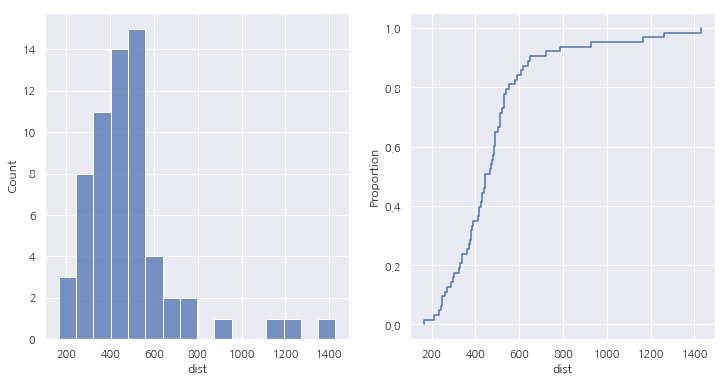

In [16]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
sns.histplot(bus_stop_ulsan_1['dist'], ax=ax1)
ax2 = fig.add_subplot(1,2,2)
sns.ecdfplot(bus_stop_ulsan_1['dist'], ax=ax2)

In [17]:
bus_stop_ulsan_1.describe()

,mybi_stop_id,stop_id,longitude,latitude,경도,위도,dist
count,6.400000e+01,64.000000,64.000000,64.000000,63.000000,63.000000,63.000000
mean,3.101221e+06,31026.968750,129.362940,35.529956,129.362189,35.530767,485.539683
std,5.720115e+02,7008.917064,0.060508,0.021229,0.060692,0.020374,228.851327
min,3.100057e+06,19016.000000,129.246863,35.477671,129.246863,35.477671,165.000000
25%,3.101193e+06,24228.500000,129.315362,35.524796,129.313682,35.526354,366.000000
50%,3.101454e+06,30618.000000,129.377473,35.535213,129.375853,35.535279,444.000000
75%,3.101483e+06,40404.000000,129.420185,35.540175,129.421187,35.540551,530.000000
max,3.102806e+06,40613.000000,129.432980,35.561309,129.432980,35.561309,1429.000000


In [18]:
marketplace = pd.read_csv('data/울산광역시_상권정보_201231.csv')

In [19]:
marketplace.shape

(52188, 39)

In [20]:
marketplace.head(3)

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,20736666,삼산프리미어어학원,NaN,R,학문/교육,R04,학원-어학,R04A01,학원-외국어/어학,P85502,외국어학원,31,울산광역시,31140,남구,3114057000,삼산동,3.114011e+09,삼산동,3.114010e+18,1,대지,1546,3.0,울산광역시 남구 삼산동 1546-3,3.114030e+11,울산광역시 남구 돋질로,286,NaN,3.114010e+24,NaN,울산광역시 남구 돋질로 286,680816,44705,NaN,NaN,NaN,129.336091,35.544065
1,24090929,왕생이입시단과학원,NaN,R,학문/교육,R01,학원-보습교습입시,R01A01,학원-입시,P85501,일반 교과 학원,31,울산광역시,31140,남구,3114055000,신정5동,3.114010e+09,신정동,3.114010e+18,1,대지,80,19.0,울산광역시 남구 신정동 80-19,3.114040e+11,울산광역시 남구 월평로147번길,5,NaN,3.114010e+24,NaN,울산광역시 남구 월평로147번길 5,680010,44685,NaN,NaN,NaN,129.320966,35.545070
2,21683173,이벤트기획연,NaN,F,생활서비스,F20,행사/이벤트,F20A02,이벤트기획,N75992,전시 및 행사 대행업,31,울산광역시,31140,남구,3114055000,신정5동,3.114010e+09,신정동,3.114060e+18,1,대지,236,107.0,울산광역시 남구 신정동 236-107,3.114030e+11,울산광역시 남구 월평로,141,NaN,3.114010e+24,NaN,울산광역시 남구 월평로 141,680010,44685,NaN,NaN,NaN,129.320748,35.544531


In [21]:
list(marketplace['상권업종중분류명'].unique())

['학원-어학',
 '학원-보습교습입시',
 '행사/이벤트',
 '한식',
 '학문교육기타',
 '의약/의료품소매',
 '종합소매점',
 '기타음식업',
 '유흥주점',
 '커피점/카페',
 '음/식료품소매',
 '이/미용/건강',
 '자동차/자동차용품',
 '가방/신발/액세서리',
 '호텔/콘도',
 '운동/경기용품소매',
 '유아교육',
 '화장품소매',
 '모텔/여관/여인숙',
 '학원-음악미술무용',
 '학원기타',
 '선물/팬시/기념품',
 '부동산중개',
 '닭/오리요리',
 '가정/주방/인테리어',
 '일식/수산물',
 'PC/오락/당구/볼링등',
 '제과제빵떡케익',
 '의복의류',
 '책/서적/도서',
 '중식',
 '건강/미용식품',
 '자동차/이륜차',
 '기타판매업',
 '분식',
 '사진/광학/정밀기기소매',
 '주유소/충전소',
 '세탁/가사서비스',
 '별식/퓨전요리',
 '가전제품소매',
 '양식',
 '민박/하숙',
 '인력/고용/용역알선',
 '철물/난방/건설자재소매',
 '페인트/유리제품소매',
 '무도/유흥/가무',
 '시계/귀금속소매',
 '주택수리',
 '가구소매',
 '장례/묘지',
 '도서관/독서실',
 '물품기기대여',
 '사무/문구/컴퓨터',
 '학원-예능취미체육',
 '캠프/별장/펜션',
 '학원-자격/국가고시',
 '중고품소매/교환',
 '개인서비스',
 '운송/배달/택배',
 '기타서비스업',
 '패스트푸드',
 '요가/단전/마사지',
 '경마/경륜/성인오락',
 '취미/오락관련소매',
 '대중목욕탕/휴게',
 '예식/의례/관혼상제',
 '분양',
 '애견/애완/동물',
 '광고/인쇄',
 '개인/가정용품수리',
 '유아용품',
 '사진',
 '학원-컴퓨터',
 '부페',
 '학원-창업취업취미',
 '연극/영화/극장',
 '대행업',
 '실내운동시설',
 '예술품/골동품/수석/분재',
 '놀이/여가/취미',
 '스포츠/운동',
 '법무세무회계',
 '음식배달서비스',
 '운영관리시설',
 '종교용품판매',
 

In [22]:
bus_stop_ulsan.shape

(64, 5)

In [23]:
marketplace.shape

(52188, 39)

In [24]:
from multiprocessing_on_dill import Pool, cpu_count
from functools import partial
import pandas as pd
import numpy as np

def parallelize_dataframe(df, 
                          func, 
                          group_keys = None, 
                          num_cores = None,
                          **params):
    """
        Pandas DataFrame의 apply함수를 병렬처리 하는 함수

        Args: 
            df: 적용 대상 데이터프레임 (Pandas.DataFrame)
            group_keys: apply를 적용할 때 기준이되는 group by key

        Returns:
            df: (Pandas.DataFrame)
            
        Exception: 
    """

    if num_cores is None:
        num_cores = cpu_count()

    if group_keys is None:
        df_list = np.array_split(df, num_cores)
    elif group_keys is not None:
        gr_df = df.groupby(group_keys)
        df_list = [group for name, group in gr_df]
    
#     func = partial(func, **params)
    
    def map_func(data):
        return data.apply(func, axis = 1, **params)
        
        
    with Pool(num_cores) as p:

        pd_result = pd.concat(p.map(map_func, df_list))
#         pd_result = p.starmap(func, **params)
        
    return pd_result

In [25]:
bus_stop_ulsan.head(3)

,mybi_stop_id,stop_id,longitude,latitude,stop_nm
0,3100597,30504,129.246863,35.529520,율리공영차고지
1,3100339,30714,129.255322,35.537435,우신고등학교입구
2,3101462,30712,129.257440,35.539800,울산과학대학앞


In [26]:
def countNearMarket(bus_stop, marketDf, dist = 250, category_list = None):
    data_copy = bus_stop.copy()
    if category_list == None:
        category_list = list(marketDf['상권업종중분류명'].unique())
        
    dist_list = marketDf.apply(lambda x: calDist(bus_stop, x), 1)
    within_data = marketDf.loc[dist_list <= dist]
    
    for i, ctgr in enumerate(category_list):
        data_copy[f"market_lv2_{i}"] = (within_data["상권업종중분류명"] == ctgr).sum()

    return data_copy

In [27]:
%%time
bus_stop_401_store = parallelize_dataframe(df = bus_stop_ulsan_1, func = countNearMarket, num_cores = 20, marketDf = marketplace, dist = 250)

CPU times: user 33.6 s, sys: 1.4 s, total: 35 s
Wall time: 1min 3s


In [28]:
bus_stop_401_store.head(3)

,mybi_stop_id,stop_id,longitude,latitude,stop_nm,경도,위도,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89
0,3100597,30504,129.246863,35.529520,율리공영차고지,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3100339,30714,129.255322,35.537435,우신고등학교입구,129.246863,35.529520,1166.0,0,4,0,15,0,0,8,0,0,6,2,10,3,0,0,0,2,3,1,3,2,1,6,3,4,8,1,0,2,1,0,1,5,1,2,0,0,5,0,0,3,0,0,2,0,0,0,1,0,0,1,0,3,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3101462,30712,129.257440,35.539800,울산과학대학앞,129.255322,35.537435,325.0,3,7,0,45,0,0,15,1,9,18,6,24,1,1,0,1,3,4,0,5,2,3,8,12,4,7,8,0,12,1,9,3,2,4,22,5,0,5,0,0,10,0,3,2,0,5,1,1,0,0,4,0,13,1,0,0,0,0,0,1,3,0,1,0,0,0,1,1,0,5,0,3,1,0,1,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0


In [29]:
%%time
hospital_data = pd.read_parquet('model_mr/hospital_data.parquet', engine='pyarrow')

CPU times: user 20.3 ms, sys: 4.91 ms, total: 25.3 ms
Wall time: 16.1 ms


In [30]:
hospital_data.head(3)

,의료기관명,의료기관종별,의료기관주소(도로명),lat_lng,lat,lng
0,의료법인 정안의료재단 중앙병원,종합병원,울산광역시 남구 문수로480번길 10 (신정동),"{'lat': 35.5315233, 'lng': 129.3052032}",35.531523,129.305203
1,의료법인 은성의료재단 좋은삼정병원,종합병원,울산광역시 남구 북부순환도로 51 (무거동),"{'lat': 35.5528284, 'lng': 129.2690588}",35.552828,129.269059
2,의료법인혜명심의료재단 울산병원,종합병원,울산광역시 남구 월평로171번길 13 (신정동),"{'lat': 35.546209, 'lng': 129.3230784}",35.546209,129.323078


In [31]:
hospital_data = hospital_data.rename(columns={"lat":"위도", "lng":"경도"})

In [32]:
def countNearHospital(bus_stop, hospitalDf, dist = 250, category_list = None):
    data_copy = bus_stop.copy()
    if category_list == None:
        category_list = list(hospitalDf['의료기관종별'].unique())
        
    dist_list = hospitalDf.apply(lambda x: calDist(bus_stop, x), 1)
    within_data = hospitalDf.loc[dist_list <= dist]
    
    for i, ctgr in enumerate(category_list):
        data_copy[f"hospital_lv1_{i}"] = (within_data["의료기관종별"] == ctgr).sum()

    return data_copy

In [33]:
%%time
bus_stop_401_hospital = parallelize_dataframe(df = bus_stop_401_store, func = countNearHospital, num_cores = 10, hospitalDf = hospital_data, dist = 250)

CPU times: user 416 ms, sys: 138 ms, total: 554 ms
Wall time: 2.42 s


In [34]:
bus_stop_401_hospital1 = bus_stop_401_hospital.copy()

In [35]:
bus_stop_401_hospital['hospital_lv0'] = bus_stop_401_hospital[[x for x in bus_stop_401_hospital.columns if "hospital" in x]].sum(axis=1)
bus_stop_401_hospital['market_lv0'] = bus_stop_401_hospital[[x for x in bus_stop_401_hospital.columns if "market" in x]].sum(axis=1)

In [36]:
bus_stop_401_hospital.head(3)

,mybi_stop_id,stop_id,longitude,latitude,stop_nm,경도,위도,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
0,3100597,30504,129.246863,35.529520,율리공영차고지,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3100339,30714,129.255322,35.537435,우신고등학교입구,129.246863,35.529520,1166.0,0,4,0,15,0,0,8,0,0,6,2,10,3,0,0,0,2,3,1,3,2,1,6,3,4,8,1,0,2,1,0,1,5,1,2,0,0,5,0,0,3,0,0,2,0,0,0,1,0,0,1,0,3,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117
2,3101462,30712,129.257440,35.539800,울산과학대학앞,129.255322,35.537435,325.0,3,7,0,45,0,0,15,1,9,18,6,24,1,1,0,1,3,4,0,5,2,3,8,12,4,7,8,0,12,1,9,3,2,4,22,5,0,5,0,0,10,0,3,2,0,5,1,1,0,0,4,0,13,1,0,0,0,0,0,1,3,0,1,0,0,0,1,1,0,5,0,3,1,0,1,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,314


In [37]:
bus_stop_401_hospital.describe()

,mybi_stop_id,stop_id,longitude,latitude,경도,위도,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
count,6.400000e+01,64.000000,64.000000,64.000000,63.000000,63.000000,63.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.00000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.0,64.000000,64.0,64.000000,64.0,64.000000,64.0,64.000000,64.00000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.0,64.0,64.000000,64.000000
mean,3.101221e+06,31026.968750,129.362940,35.529956,129.362189,35.530767,485.539683,3.453125,5.703125,0.062500,26.671875,0.468750,0.375000,7.781250,0.250000,16.546875,8.140625,3.281250,12.593750,1.046875,4.015625,0.390625,2.015625,0.984375,4.921875,2.812500,1.984375,2.140625,1.734375,3.890625,3.984375,3.281250,6.593750,2.000000,2.203125,12.093750,0.656250,2.281250,1.484375,2.625000,0.593750,5.578125,2.906250,0.250000,2.281250,1.046875,1.062500,5.312500,0.0,0.265625,0.734375,0.078125,3.500000,1.062500,0.265625,0.718750,0.078125,0.765625,0.265625,1.281250,0.781250,0.0,0.343750,0.437500,0.187500,0.250000,0.265625,3.250000,1.250000,0.437500,0.265625,0.812500,0.312500,0.312500,0.296875,0.562500,1.046875,0.21875,0.468750,0.203125,0.312500,0.109375,0.093750,0.468750,0.171875,0.093750,0.015625,0.0,0.078125,0.171875,0.0,0.015625,0.0,0.078125,0.0,0.046875,0.0,0.015625,0.15625,0.015625,0.0,0.140625,4.140625,0.015625,2.750000,0.078125,1.328125,1.750000,0.0,0.0,0.0,10.390625,189.875000
std,5.720115e+02,7008.917064,0.060508,0.021229,0.060692,0.020374,228.851327,8.635346,18.833169,0.243975,28.349326,0.890314,0.745356,6.574286,0.854493,27.933555,11.365315,6.703396,14.998115,1.350246,14.431549,1.149426,4.001953,1.290898,12.130644,4.760536,3.790096,3.580668,2.234237,4.979696,4.772581,3.692415,8.158584,2.986743,3.582053,39.160524,1.275144,3.114068,2.288634,2.627691,1.003466,

In [38]:
%%time
mybicard_401_agg_10m = (mybicard_401.loc[(mybicard_401["transflag"] != "하차")]
                                   .groupby(["mybi_stop_id", 'base_ymd', 
                                             pd.Grouper(key="transdate", freq='10Min')])
                                   .agg({"totalcnt" : sum, "normalcnt": sum, "studentcnt" : sum, "childcnt": sum})
                                   .reset_index())

CPU times: user 745 ms, sys: 191 ms, total: 936 ms
Wall time: 932 ms


In [39]:
# 요일, 날짜, 월 변수 생성
mybicard_401_agg_10m["dayofweek"] = mybicard_401_agg_10m["transdate"].dt.dayofweek
dow_dict = {0:"월", 1:"화", 2:"수", 3:"목", 4:"금", 5:"토", 6:"일"}
mybicard_401_agg_10m["dayofweek"] = mybicard_401_agg_10m["dayofweek"].replace(dow_dict)
mybicard_401_agg_10m["month"] = mybicard_401_agg_10m["transdate"].dt.month
mybicard_401_agg_10m["day"] = mybicard_401_agg_10m["transdate"].dt.day
mybicard_401_agg_10m["hour"] = mybicard_401_agg_10m["transdate"].dt.hour
mybicard_401_agg_10m["min"] = mybicard_401_agg_10m["transdate"].dt.minute

In [40]:
mybicard_401_agg_10m.head(3)

,mybi_stop_id,base_ymd,transdate,totalcnt,normalcnt,studentcnt,childcnt,dayofweek,month,day,hour,min
0,3100020,20200408,2020-04-08 06:30:00,1,1,0,0,수,4,8,6,30
1,3100020,20200408,2020-04-08 06:40:00,1,1,0,0,수,4,8,6,40
2,3100020,20200408,2020-04-08 08:10:00,3,3,0,0,수,4,8,8,10


In [41]:
# 마이비 정류장 ID -> 공공 데이터 정류쟝 ID로 매핑
bus_demand_401_10m = pd.merge(mybicard_401_agg_10m, bus_stop_401_hospital, on = "mybi_stop_id", how = "inner")
bus_demand_401_10m

,mybi_stop_id,base_ymd,transdate,totalcnt,normalcnt,studentcnt,childcnt,dayofweek,month,day,hour,min,stop_id,longitude,latitude,stop_nm,경도,위도,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
0,3100057,20200408,2020-04-08 06:30:00,3,3,0,0,수,4,8,6,30,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
1,3100057,20200408,2020-04-08 06:40:00,1,1,0,0,수,4,8,6,40,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
2,3100057,20200408,2020-04-08 09:00:00,1,1,0,0,수,4,8,9,0,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
3,3100057,20200408,2020-04-08 10:10:00,1,1,0,0,수,4,8,10,10,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
4,3100057,20200408,2020-04-08 11:30:00,1,1,0,0,수,4,8,11,30,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
5,3100057,20200408,2020-04-08 14:10:00,1,1,0,0,수,4,8,14,10,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
6,3100057,20200408,2020-04-08 14:30:00,1,1,0,0,수,4,8,14,30,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
7,3100057,20200408,2020-

In [42]:
bus_demand_401_10m.shape

(401746, 125)

In [43]:
bus_demand_401_10m.head(3)

,mybi_stop_id,base_ymd,transdate,totalcnt,normalcnt,studentcnt,childcnt,dayofweek,month,day,hour,min,stop_id,longitude,latitude,stop_nm,경도,위도,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
0,3100057,20200408,2020-04-08 06:30:00,3,3,0,0,수,4,8,6,30,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
1,3100057,20200408,2020-04-08 06:40:00,1,1,0,0,수,4,8,6,40,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
2,3100057,20200408,2020-04-08 09:00:00,1,1,0,0,수,4,8,9,0,30619,129.381424,35.552756,현대자동차2공장,129.379093,35.556672,484.0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,2,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17


In [97]:
bus_demand_401_10m.to_parquet("model_mr/bus_demand_401_10m.parquet")

In [44]:
bus_demand_401_10m.describe()

,mybi_stop_id,base_ymd,totalcnt,normalcnt,studentcnt,childcnt,month,day,hour,min,stop_id,longitude,latitude,경도,위도,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
count,4.017460e+05,4.017460e+05,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,395420.000000,395420.000000,395420.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.0,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.0,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.00000,401746.000000,401746.0,401746.000000,401746.000000,401746.0,401746.000000,401746.0,401746.000000,401746.0,401746.000000,401746.0,401746.000000,401746.000000,401746.000000,401746.0,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.000000,401746.0,401746.0,401746.0,401746.000000,401746.000000
mean,3.101264e+06,2.020076e+07,2.523423,2.300050,0.213043,0.010330,7.475706,15.626319,13.853034,24.766768,33772.962003,129.336426,35.534413,129.334704,35.534429,459.541606,6.094550,10.486882,0.071866,39.670406,0.735022,0.593962,10.830851,0.214519,25.271291,12.854015,4.376865,19.604469,1.392449,7.472931,0.729941,3.237543,1.165137,9.180485,3.985075,3.629915,3.375384,2.692781,6.487602,5.963646,4.745439,9.582107,3.206372,3.722382,23.828631,1.207788,3.522402,2.461911,3.013884,0.872536,8.380763,5.046509,0.270153,2.812608,1.667479,1.816513,9.145370,0.0,0.389871,1.077131,0.098821,5.556449,2.213712,0.368302,1.188301,0.103478,1.418177,0.388639,1.999360,1.370329,0.0,0.758355,0.643889,0.303692,0.319764,0.495661,5.472313,2.246290,0.698830,0

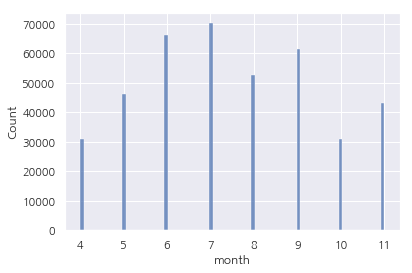

In [45]:
sns.histplot(bus_demand_401_10m['month'])

In [46]:
bus_demand_401_10m.groupby(['dayofweek', 'month'])['mybi_stop_id'].count()

dayofweek  month
금          4         4711
           5        11633
           6         9931
           7        12488
           8         6995
           9         9492
           10        2946
           11        4764
목          4         4468
           5         2446
           6         9418
           7        12473
           8         7193
           9         8917
           10        5843
           11        7096
수          4         2169
           5         9732
           6         9745
           7        12203
           8         9511
           9        10291
           10        4903
           11        7179
월          4         6846
           5         7028
           6        11963
           7         9547
           8         8500
           9         9021
           10        4741
           11        6984
일          4         2496
           5         5538
           6         5773
           7         6093
           8         6873
           9         

In [48]:
import plotly.express as px

In [58]:
day_sorter = ['월', '화', '수', '목', '금', '토', '일']

In [59]:
bus_demand_groupby_day = bus_demand_401_10m.groupby(['dayofweek', 'month'])['mybi_stop_id'].count().reset_index().copy()

In [63]:
bus_demand_groupby_day['rank'] = bus_demand_groupby_day['dayofweek'].map(dict(zip(day_sorter, range(len(day_sorter)))))

In [73]:
fig = px.scatter(bus_demand_groupby_day.sort_values(['rank','month'])
                 , x="dayofweek", y="month", color="mybi_stop_id", color_continuous_scale=px.colors.sequential.OrRd)
fig.show()

In [76]:
bus_demand_pivot = bus_demand_groupby_day.sort_values(['rank','month']).pivot(index='month', columns='dayofweek', values='mybi_stop_id').copy()

In [117]:
bus_demand_pivot_sorted = bus_demand_pivot[day_sorter].copy()

In [118]:
bus_demand_pivot_sorted['col_sum'] = bus_demand_pivot_sorted.sum(axis=1)
bus_demand_pivot_sorted = bus_demand_pivot_sorted.append(pd.Series(bus_demand_pivot_sorted.sum(axis=0), name='row_sum'))
bus_demand_pivot_sorted

dayofweek,월,화,수,목,금,토,일,col_sum
month,,,,,,,,
4,6846,6787,2169,4468,4711,3363,2496,30840
5,7028,4818,9732,2446,11633,4939,5538,46134
6,11963,12132,9745,9418,9931,7157,5773,66119
7,9547,9873,12203,12473,12488,7523,6093,70200
8,8500,6848,9511,7193,6995,6637,6873,52557
9,9021,11719,10291,8917,9492,6988,5096,61524
10,4741,4843,4903,5843,2946,5058,2739,31073
11,6984,7118,7179,7096,4764,5647,4511,43299
row_sum,64630,64138,65733,57854,62960,47312,39119,401746


In [119]:
bus_demand_pivot_sorted['col_pct'] = round(bus_demand_pivot_sorted['col_sum']/bus_demand_pivot_sorted['col_sum']['row_sum'],3) * 100
bus_demand_pivot_sorted = bus_demand_pivot_sorted.append(pd.Series(round(bus_demand_pivot_sorted.loc['row_sum']/bus_demand_pivot_sorted['col_sum']['row_sum'],3)*100, name='row_pct'))
bus_demand_pivot_sorted

dayofweek,월,화,수,목,금,토,일,col_sum,col_pct
month,,,,,,,,,
4,6846.0,6787.0,2169.0,4468.0,4711.0,3363.0,2496.0,30840.0,7.7
5,7028.0,4818.0,9732.0,2446.0,11633.0,4939.0,5538.0,46134.0,11.5
6,11963.0,12132.0,9745.0,9418.0,9931.0,7157.0,5773.0,66119.0,16.5
7,9547.0,9873.0,12203.0,12473.0,12488.0,7523.0,6093.0,70200.0,17.5
8,8500.0,6848.0,9511.0,7193.0,6995.0,6637.0,6873.0,52557.0,13.1
9,9021.0,11719.0,10291.0,8917.0,9492.0,6988.0,5096.0,61524.0,15.3
10,4741.0,4843.0,4903.0,5843.0,2946.0,5058.0,2739.0,31073.0,7.7
11,6984.0,7118.0,7179.0,7096.0,4764.0,5647.0,4511.0,43299.0,10.8
row_sum,64630.0,64138.0,65733.0,57854.0,62960.0,47312.0,39119.0,401746.0,100.0


In [100]:
import statsmodels.api as sm
from scipy import stats

In [98]:
X0 = bus_demand_401_10m[[x for x in bus_demand_401_10m.columns if ("market" in x) | ("hospital" in x)]]
X1 = bus_demand_401_10m[[x for x in bus_demand_401_10m.columns if "market" in x]]
X2 = bus_demand_401_10m[[x for x in bus_demand_401_10m.columns if "hospital" in x]]
y = bus_demand_401_10m["totalcnt"]

In [102]:
%%time
X0_ = sm.add_constant(X0)
est_0 = sm.OLS(y, X0_)
est2_0 = est_0.fit()
print(est2_0.summary())

                            OLS Regression Results                            
Dep. Variable:               totalcnt   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     1422.
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        04:32:53   Log-Likelihood:            -8.8090e+05
No. Observations:              401746   AIC:                         1.762e+06
Df Residuals:                  401682   BIC:                         1.763e+06
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6684      0.027     

In [103]:
%%time
X1_ = sm.add_constant(X1)
est_1 = sm.OLS(y, X1_)
est2_1 = est_1.fit()
print(est2_1.summary())

                            OLS Regression Results                            
Dep. Variable:               totalcnt   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     1467.
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        04:33:11   Log-Likelihood:            -8.8093e+05
No. Observations:              401746   AIC:                         1.762e+06
Df Residuals:                  401684   BIC:                         1.763e+06
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.7062      0.026     64.884

In [104]:
%%time
X2_ = sm.add_constant(X2)
est_2 = sm.OLS(y, X2_)
est2_2 = est_2.fit()
print(est2_2.summary())

/home/ds_user1/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:               totalcnt   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     4966.
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        04:33:14   Log-Likelihood:            -8.9792e+05
No. Observations:              401746   AIC:                         1.796e+06
Df Residuals:                  401735   BIC:                         1.796e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.1057      0.006    3

In [105]:
p_values0 = est2_0.pvalues
insignificant_list0 = p_values0.loc[p_values0 >=0.05]
insignificant_list0

market_lv2_4      0.169601
market_lv2_7      0.534098
market_lv2_14     0.714402
market_lv2_15     0.090210
market_lv2_16     0.395618
market_lv2_20     0.069942
market_lv2_23     0.920636
market_lv2_26     0.871684
market_lv2_35     0.161116
market_lv2_38     0.079997
market_lv2_41     0.069921
market_lv2_43     0.378555
market_lv2_44     0.612752
market_lv2_45     0.160313
market_lv2_48     0.145835
market_lv2_54     0.685208
market_lv2_60     0.164206
market_lv2_62     0.105471
market_lv2_65     0.495171
market_lv2_73     0.739594
market_lv2_74     0.465442
hospital_lv1_1    0.088064
hospital_lv1_4    0.116633
hospital_lv1_8    0.442459
dtype: float64

In [106]:
p_values1 = est2_1.pvalues
insignificant_list1 = p_values1.loc[p_values1 >=0.05]
insignificant_list1

market_lv2_9     0.556084
market_lv2_16    0.956673
market_lv2_20    0.685177
market_lv2_23    0.077176
market_lv2_24    0.412335
market_lv2_26    0.078713
market_lv2_28    0.334881
market_lv2_33    0.184376
market_lv2_41    0.059516
market_lv2_44    0.397559
market_lv2_45    0.051810
market_lv2_50    0.063776
market_lv2_53    0.143855
market_lv2_68    0.874176
market_lv2_75    0.216251
market_lv2_77    0.143916
market_lv2_84    0.254513
dtype: float64

In [107]:
p_values2 = est2_2.pvalues
insignificant_list2 = p_values2.loc[p_values2 >=0.05]
insignificant_list2

hospital_lv1_0     0.672044
hospital_lv1_1     0.672044
hospital_lv1_2     0.672044
hospital_lv1_3     0.672044
hospital_lv1_4     0.672044
hospital_lv1_5     0.672044
hospital_lv1_6     0.672044
hospital_lv1_7     0.672044
hospital_lv1_8     0.672044
hospital_lv1_9     0.672044
hospital_lv1_10    0.672044
hospital_lv0       0.672044
dtype: float64